# Make a decent bar chart for feature importance

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

features = ['bedrooms','bathrooms','doorman','parking','laundry','walkup','ac','nofee','coop']
values = np.array([0.697091628, 0.181579262, 0.09046983, 0.0149105083, 0.00709949088, 0.00519591132, 0.00361618919, 3.71797701e-05, 0.0])

I = pd.DataFrame()
I['Feature'] = features
I['Importance'] = values
I = I.set_index('Feature')
I

,Importance
Feature,
bedrooms,0.697092
bathrooms,0.181579
doorman,0.090470
parking,0.014911
laundry,0.007099
walkup,0.005196
ac,0.003616
nofee,0.000037
coop,0.000000


In [2]:
features2 = ['bedrooms','bathrooms','doorman']
values2 = np.array([0.697091628, 0.181579262, 0.09046983])

I2 = pd.DataFrame()
I2['Feature'] = features2
I2['Importance'] = values2
I2 = I2.set_index('Feature')
I2

,Importance
Feature,
bedrooms,0.697092
bathrooms,0.181579
doorman,0.090470


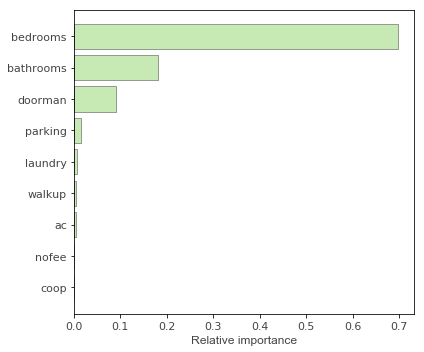

In [3]:
from rfpimp import plot_importances

plot_importances(I, width=6)

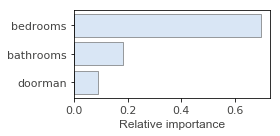

In [7]:
plot_importances(I2, width=4, barcolor='#D9E6F5')